In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv('../../assets/data/euretail.csv')
df = df.set_index(['Year'])

In [2]:
df.head()

,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
1996,89.13,89.52,89.88,90.12
1997,89.19,89.78,90.03,90.38
1998,90.27,90.77,91.85,92.51
1999,92.21,92.52,93.62,94.15
2000,94.69,95.34,96.04,96.30


In [3]:
df.stack().head()

Year         
1996     Qtr1    89.13
         Qtr2    89.52
         Qtr3    89.88
         Qtr4    90.12
1997     Qtr1    89.19
dtype: float64

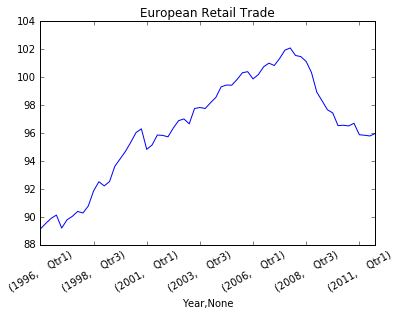

In [4]:
df.stack().plot(title='European Retail Trade', rot=30)
#Not stationary, so it's not ready for RIMA or ARIMA

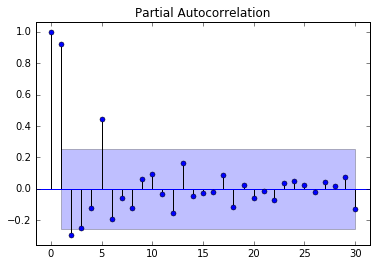

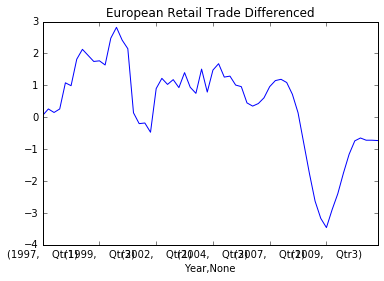

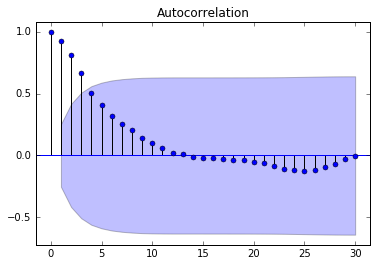

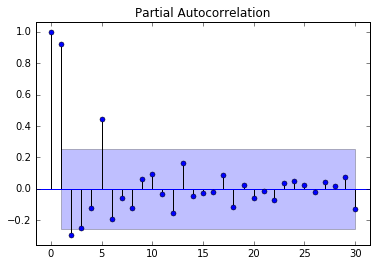

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#differencing makes this stationary and eliminates the trend in our data
diff0 = df.stack().diff(periods=4)[4:]
diff0.plot(title='European Retail Trade Differenced')
plot_acf(diff0, lags=30)
plot_pacf(diff0, lags=30)

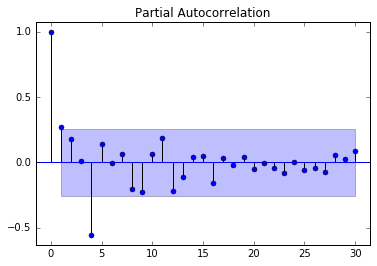

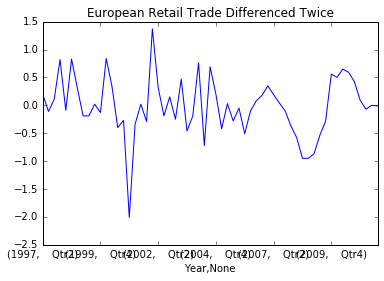

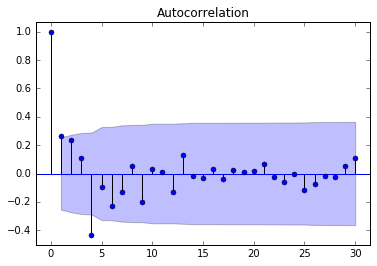

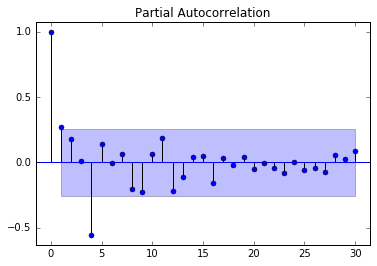

In [6]:
# Now we take the difference of the difference - remember, you're trying to get this data to be stationary(take the
# trend and seasonality out of it)
diff1 = diff0.diff()[1:]
diff1.plot(title='European Retail Trade Differenced Twice')
plot_acf(diff1, lags=30)
plot_pacf(diff1, lags=30)

In [7]:
import statsmodels.api as sm
data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Thu, 04 Aug 2016   AIC                             75.360
Time:                                   16:22:36   BIC                             81.837
Sample:                                        0   HQIC                            77.912
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.869      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240      0.000      -0.949      -0.432
sigma2         0.1812      0.034      5.307      0.000       0.114       0.248
===================================================================================
Ljung-Box (Q):                       33.87   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.74   Prob(JB):                         0.39
Heteroskedasticity (H):               0.76   Skew:                            -0.22
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

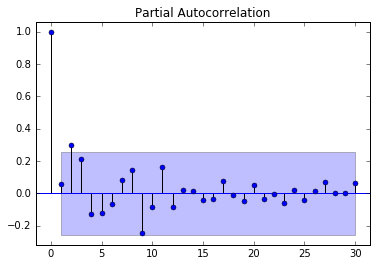

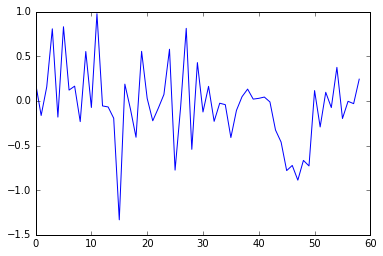

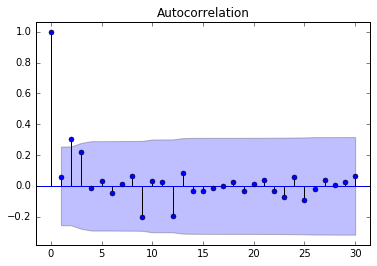

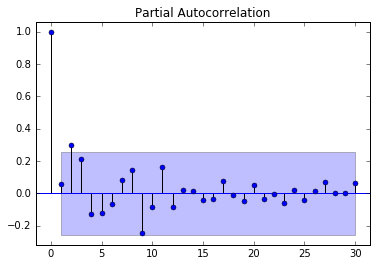

In [8]:
# Don't plot the first 5 values, to account for data loss when differencing (d=1 + D=5)
residuals = results.resid[5:]
plt.plot(residuals)

plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = min(10, len(residuals)/5)

acorr_ljungbox(residuals, lags=lags)


(array([  0.21600963,   6.07220337,   9.26512786,   9.27816153,
          9.33353081,   9.49804717,   9.50834118,   9.8201702 ,
         12.83637379,  12.9010138 ]),
 array([ 0.64209735,  0.04802173,  0.02596586,  0.05451062,  0.09647772,
         0.14744451,  0.21818848,  0.27787523,  0.17015103,  0.22925904]))

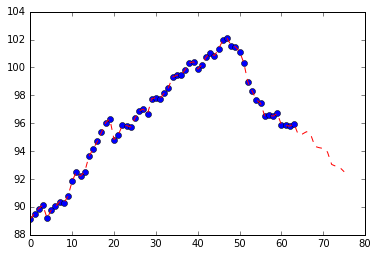

In [10]:
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,3), seasonal_order=(0,1,1,4), trend='c')
res = model.fit()

preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');